
# Video API

<div class="alert alert-info"><h4>Note</h4><p>Try on [Colab](https://colab.research.google.com/github/pytorch/vision/blob/gh-pages/main/_generated_ipynb_notebooks/plot_video_api.ipynb)
    or `go to the end <sphx_glr_download_auto_examples_others_plot_video_api.py>` to download the full example code.</p></div>

This example illustrates some of the APIs that torchvision offers for
videos, together with the examples on how to build datasets and more.


## 1. Introduction: building a new video object and examining the properties
First we select a video to test the object out. For the sake of argument
we're using one from kinetics400 dataset.
To create it, we need to define the path and the stream we want to use.



Chosen video statistics:

- WUzgd7C1pWA.mp4
    - source:
        - kinetics-400
    - video:
        - H-264
        - MPEG-4 AVC (part 10) (avc1)
        - fps: 29.97
    - audio:
        - MPEG AAC audio (mp4a)
        - sample rate: 48K Hz




In [1]:
# Desinstalar torch y torchvision si ya están instalados
!pip uninstall -y torch torchvision

# Instalar versiones específicas de torch y torchvision
!pip install torch==2.5.0 torchvision==0.20.0

# Instalar pyav (backend de video)
!pip install av

# Importar las librerías necesarias
import torch
import torchvision
from torchvision.datasets.utils import download_url

# Establecer el backend para video a 'pyav'
torchvision.set_video_backend("pyav")

# Descargar el video de ejemplo
download_url(
    "https://github.com/pytorch/vision/blob/main/test/assets/videos/WUzgd7C1pWA.mp4?raw=true",
    ".",
    "WUzgd7C1pWA.mp4"
)

# Definir la ruta del video descargado
video_path = "./WUzgd7C1pWA.mp4"

# Mostrar la ruta del video para verificar
print(f"Video descargado en: {video_path}")



Found existing installation: torch 2.5.0
Uninstalling torch-2.5.0:
  Successfully uninstalled torch-2.5.0
Found existing installation: torchvision 0.20.0
Uninstalling torchvision-0.20.0:
  Successfully uninstalled torchvision-0.20.0
  Using cached torch-2.5.0-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.20.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.1 kB)
Using cached torch-2.5.0-cp311-cp311-manylinux1_x86_64.whl (906.5 MB)
Using cached torchvision-0.20.0-cp311-cp311-manylinux1_x86_64.whl (7.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.5.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 20.5 MB/s eta 0:00:00


100%|██████████| 890k/890k [00:00<00:00, 19.7MB/s]

Video descargado en: ./WUzgd7C1pWA.mp4


Streams are defined in a similar fashion as torch devices. We encode them as strings in a form
of ``stream_type:stream_id`` where ``stream_type`` is a string and ``stream_id`` a long int.
The constructor accepts passing a ``stream_type`` only, in which case the stream is auto-discovered.
Firstly, let's get the metadata for our particular video:



In [2]:
stream = "video"
video = torchvision.io.VideoReader(video_path, stream)
video.get_metadata()

{'video': {'fps': [29.97002997002997], 'duration': [10.9109]},
 'audio': {'framerate': [48000.0], 'duration': [10.9]}}

Here we can see that video has two streams - a video and an audio stream.
Currently available stream types include ['video', 'audio'].
Each descriptor consists of two parts: stream type (e.g. 'video') and a unique stream id
(which are determined by video encoding).
In this way, if the video container contains multiple streams of the same type,
users can access the one they want.
If only stream type is passed, the decoder auto-detects first stream of that type and returns it.



Let's read all the frames from the video stream. By default, the return value of
``next(video_reader)`` is a dict containing the following fields.

The return fields are:

- ``data``: containing a torch.tensor
- ``pts``: containing a float timestamp of this particular frame



In [3]:
metadata = video.get_metadata()
video.set_current_stream("audio")

frames = []  # we are going to save the frames here.
ptss = []  # pts is a presentation timestamp in seconds (float) of each frame
for frame in video:
    frames.append(frame['data'])
    ptss.append(frame['pts'])

print("PTS for first five frames ", ptss[:5])
print("Total number of frames: ", len(frames))
approx_nf = metadata['audio']['duration'][0] * metadata['audio']['framerate'][0]
print("Approx total number of datapoints we can expect: ", approx_nf)
print("Read data size: ", frames[0].size(0) * len(frames))

PTS for first five frames  [0.0, 0.021333333333333333, 0.042666666666666665, 0.064, 0.08533333333333333]
Total number of frames:  511
Approx total number of datapoints we can expect:  523200.0
Read data size:  523264


But what if we only want to read certain time segment of the video?
That can be done easily using the combination of our ``seek`` function, and the fact that each call
to next returns the presentation timestamp of the returned frame in seconds.

Given that our implementation relies on python iterators,
we can leverage itertools to simplify the process and make it more pythonic.

For example, if we wanted to read ten frames from second second:



In [4]:
import itertools
video.set_current_stream("video")

frames = []  # we are going to save the frames here.

# We seek into a second second of the video and use islice to get 10 frames since
for frame, pts in itertools.islice(video.seek(2), 10):
    frames.append(frame)

print("Total number of frames: ", len(frames))

Total number of frames:  10


/usr/local/lib/python3.11/dist-packages/torchvision/io/video_reader.py:241: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


Or if we wanted to read from 2nd to 5th second,
We seek into a second second of the video,
then we utilize the itertools takewhile to get the
correct number of frames:



In [5]:
video.set_current_stream("video")
frames = []  # we are going to save the frames here.
video = video.seek(2)

for frame in itertools.takewhile(lambda x: x['pts'] <= 5, video):
    frames.append(frame['data'])

print("Total number of frames: ", len(frames))
approx_nf = (5 - 2) * video.get_metadata()['video']['fps'][0]
print("We can expect approx: ", approx_nf)
print("Tensor size: ", frames[0].size())

Total number of frames:  150
We can expect approx:  89.91008991008991
Tensor size:  torch.Size([3, 256, 340])


## 2. Building a sample read_video function
We can utilize the methods above to build the read video function that follows
the same API to the existing ``read_video`` function.



In [6]:
def example_read_video(video_object, start=0, end=None, read_video=True, read_audio=True):
    if end is None:
        end = float("inf")
    if end < start:
        raise ValueError(
            "end time should be larger than start time, got "
            f"start time={start} and end time={end}"
        )

    video_frames = torch.empty(0)
    video_pts = []
    if read_video:
        video_object.set_current_stream("video")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            video_pts.append(frame['pts'])
        if len(frames) > 0:
            video_frames = torch.stack(frames, 0)

    audio_frames = torch.empty(0)
    audio_pts = []
    if read_audio:
        video_object.set_current_stream("audio")
        frames = []
        for frame in itertools.takewhile(lambda x: x['pts'] <= end, video_object.seek(start)):
            frames.append(frame['data'])
            audio_pts.append(frame['pts'])
        if len(frames) > 0:
            audio_frames = torch.cat(frames, 0)

    return video_frames, audio_frames, (video_pts, audio_pts), video_object.get_metadata()


# Total number of frames should be 327 for video and 523264 datapoints for audio
vf, af, info, meta = example_read_video(video)
print(vf.size(), af.size())

torch.Size([327, 3, 256, 340]) torch.Size([523264, 1])


## 3. Building an example randomly sampled dataset (can be applied to training dataset of kinetics400)
Cool, so now we can use the same principle to make the sample dataset.
We suggest trying out iterable dataset for this purpose.
Here, we are going to build an example dataset that reads randomly selected 10 frames of video.



Make sample dataset



In [7]:
import os
os.makedirs("./dataset", exist_ok=True)
os.makedirs("./dataset/1", exist_ok=True)
os.makedirs("./dataset/2", exist_ok=True)

Download the videos



In [8]:
from torchvision.datasets.utils import download_url
download_url(
    "https://github.com/pytorch/vision/blob/main/test/assets/videos/WUzgd7C1pWA.mp4?raw=true",
    "./dataset/1", "WUzgd7C1pWA.mp4"
)
download_url(
    "https://github.com/pytorch/vision/blob/main/test/assets/videos/RATRACE_wave_f_nm_np1_fr_goo_37.avi?raw=true",
    "./dataset/1",
    "RATRACE_wave_f_nm_np1_fr_goo_37.avi"
)
download_url(
    "https://github.com/pytorch/vision/blob/main/test/assets/videos/SOX5yA1l24A.mp4?raw=true",
    "./dataset/2",
    "SOX5yA1l24A.mp4"
)
download_url(
    "https://github.com/pytorch/vision/blob/main/test/assets/videos/v_SoccerJuggling_g23_c01.avi?raw=true",
    "./dataset/2",
    "v_SoccerJuggling_g23_c01.avi"
)
download_url(
    "https://github.com/pytorch/vision/blob/main/test/assets/videos/v_SoccerJuggling_g24_c01.avi?raw=true",
    "./dataset/2",
    "v_SoccerJuggling_g24_c01.avi"
)

100%|██████████| 890k/890k [00:00<00:00, 22.8MB/s]


100%|██████████| 264k/264k [00:00<00:00, 13.8MB/s]


100%|██████████| 560k/560k [00:00<00:00, 17.8MB/s]


100%|██████████| 508k/508k [00:00<00:00, 18.0MB/s]


100%|██████████| 623k/623k [00:00<00:00, 14.1MB/s]


Housekeeping and utilities



In [9]:
import os
import random

from torchvision.datasets.folder import make_dataset
from torchvision import transforms as t


def _find_classes(dir):
    classes = [d.name for d in os.scandir(dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


def get_samples(root, extensions=(".mp4", ".avi")):
    _, class_to_idx = _find_classes(root)
    return make_dataset(root, class_to_idx, extensions=extensions)

We are going to define the dataset and some basic arguments.
We assume the structure of the FolderDataset, and add the following parameters:

- ``clip_len``: length of a clip in frames
- ``frame_transform``: transform for every frame individually
- ``video_transform``: transform on a video sequence

<div class="alert alert-info"><h4>Note</h4><p>We actually add epoch size as using :func:`~torch.utils.data.IterableDataset`
  class allows us to naturally oversample clips or images from each video if needed.</p></div>



In [10]:
class RandomDataset(torch.utils.data.IterableDataset):
    def __init__(self, root, epoch_size=None, frame_transform=None, video_transform=None, clip_len=16):
        super(RandomDataset).__init__()

        self.samples = get_samples(root)

        # Allow for temporal jittering
        if epoch_size is None:
            epoch_size = len(self.samples)
        self.epoch_size = epoch_size

        self.clip_len = clip_len
        self.frame_transform = frame_transform
        self.video_transform = video_transform

    def __iter__(self):
        for i in range(self.epoch_size):
            # Get random sample
            path, target = random.choice(self.samples)
            # Get video object
            vid = torchvision.io.VideoReader(path, "video")
            metadata = vid.get_metadata()
            video_frames = []  # video frame buffer

            # Seek and return frames
            max_seek = metadata["video"]['duration'][0] - (self.clip_len / metadata["video"]['fps'][0])
            start = random.uniform(0., max_seek)
            for frame in itertools.islice(vid.seek(start), self.clip_len):
                video_frames.append(self.frame_transform(frame['data']))
                current_pts = frame['pts']
            # Stack it into a tensor
            video = torch.stack(video_frames, 0)
            if self.video_transform:
                video = self.video_transform(video)
            output = {
                'path': path,
                'video': video,
                'target': target,
                'start': start,
                'end': current_pts}
            yield output

Given a path of videos in a folder structure, i.e:

- dataset
    - class 1
        - file 0
        - file 1
        - ...
    - class 2
        - file 0
        - file 1
        - ...
    - ...

We can generate a dataloader and test the dataset.



In [11]:
transforms = [t.Resize((112, 112))]
frame_transform = t.Compose(transforms)

dataset = RandomDataset("./dataset", epoch_size=None, frame_transform=frame_transform)

In [12]:
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=12)
data = {"video": [], 'start': [], 'end': [], 'tensorsize': []}
for batch in loader:
    for i in range(len(batch['path'])):
        data['video'].append(batch['path'][i])
        data['start'].append(batch['start'][i].item())
        data['end'].append(batch['end'][i].item())
        data['tensorsize'].append(batch['video'][i].size())
print(data)

{'video': ['./dataset/2/SOX5yA1l24A.mp4', './dataset/2/v_SoccerJuggling_g23_c01.avi', './dataset/1/WUzgd7C1pWA.mp4', './dataset/2/v_SoccerJuggling_g24_c01.avi', './dataset/2/SOX5yA1l24A.mp4'], 'start': [10.446720024287066, 6.298865618388633, 1.5892969832953954, 3.170191721430514, 7.0521518953247115], 'end': [10.243566666666666, 6.5065, 0.5005, 3.3033, 5.1051], 'tensorsize': [torch.Size([16, 3, 112, 112]), torch.Size([16, 3, 112, 112]), torch.Size([16, 3, 112, 112]), torch.Size([16, 3, 112, 112]), torch.Size([16, 3, 112, 112])]}


## 4. Data Visualization
Example of visualized video



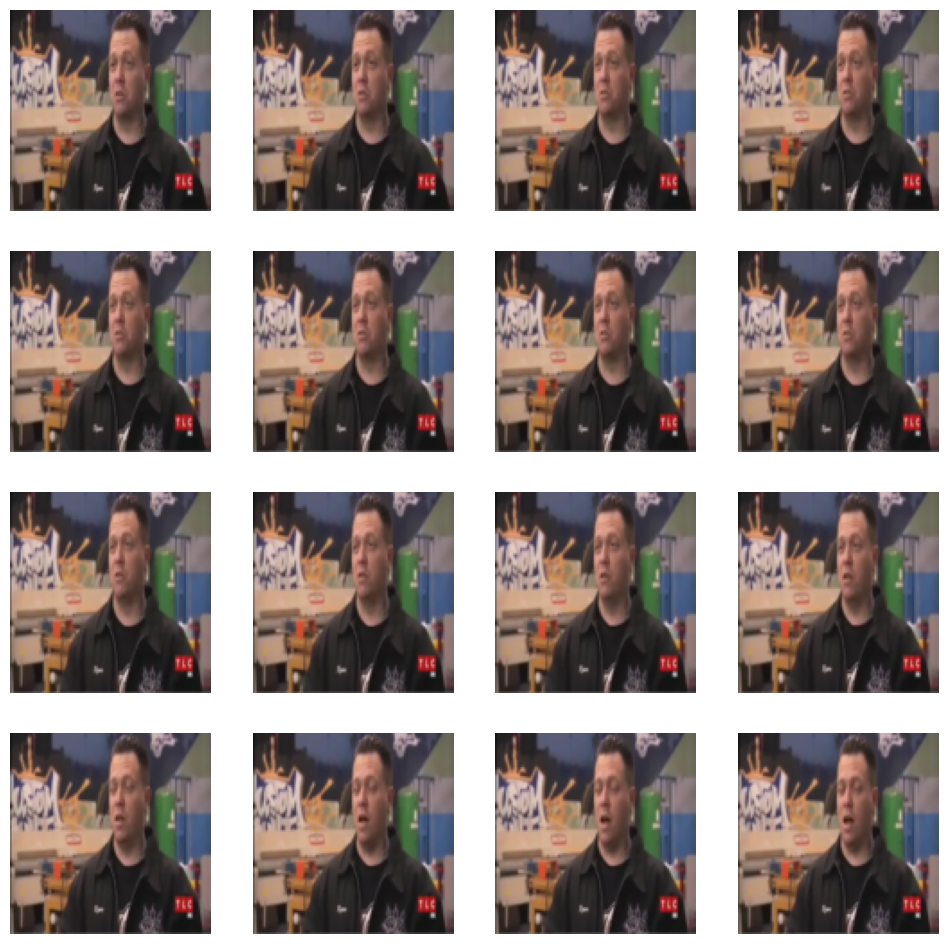

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(batch["video"][0, i, ...].permute(1, 2, 0))
    plt.axis("off")

Cleanup the video and dataset:



In [14]:
import os
import shutil
os.remove("./WUzgd7C1pWA.mp4")
shutil.rmtree("./dataset")